### Importing Necessary Packages

In [1]:
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
import lightgbm as lgbm
from skopt.space import Real,Integer, Categorical
from skopt import BayesSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [2]:
train_org=pd.read_csv('train.csv')

In [3]:
train = train_org.copy()

### EDA

In [4]:
train.shape

(891, 12)

In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Changing Sex to Binary Value

In [9]:
sex = [0]*len(train)
for i in range(len(train)):
    if train['Sex'].loc[i] == 'male':
        sex[i] = 1
train['Sex'] = sex

Approximating Age for Null Values:
-Median age for different sexes and classes are different, and therefore approximated differently

In [10]:
def age_aproximate(row,data):
    groups_median = data.iloc[:len(train)].groupby(['Sex','Pclass'])
    g_m_train = groups_median.median()
    g_m_train = g_m_train.reset_index()[['Sex', 'Pclass', 'Age']]
    output = ((g_m_train['Sex'] == row['Sex'])  & (g_m_train['Pclass'] == row['Pclass'])) 
    return g_m_train[output]['Age'].values[0]

In [11]:
train['Age'] = train.apply(lambda row: age_aproximate(row,train) if np.isnan(row['Age']) else row['Age'], axis=1)

Visualizing how the features interact

In [12]:
corr = train.corr()
corr.style.background_gradient(cmap='coolwarm')

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.042939,0.039033,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.543351,-0.059579,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,0.131900,-0.413583,0.083081,0.018443,-0.549500
Sex,0.042939,-0.543351,0.131900,1.000000,0.102706,-0.114631,-0.245489,-0.182333
Age,0.039033,-0.059579,-0.413583,0.102706,1.000000,-0.249854,-0.175526,0.122692
SibSp,-0.057527,-0.035322,0.083081,-0.114631,-0.249854,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.245489,-0.175526,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,-0.182333,0.122692,0.159651,0.216225,1.000000


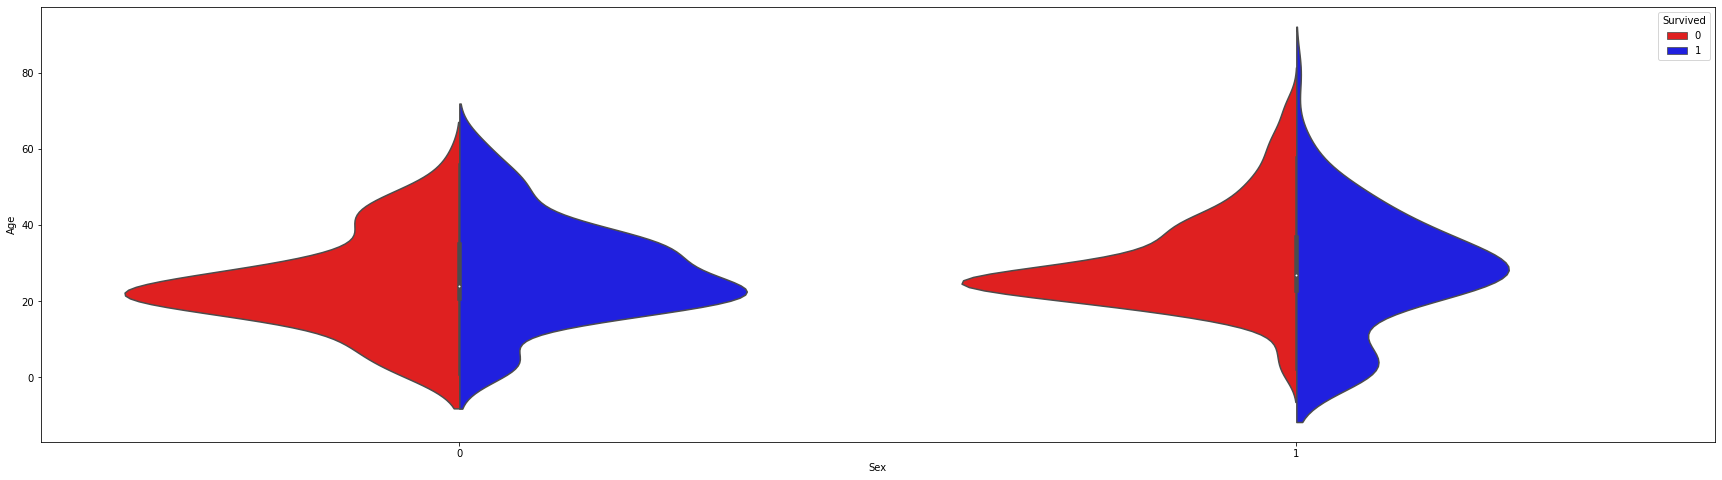

In [13]:
fig = plt.figure(figsize=(30, 8))
sns.violinplot(x='Sex', y='Age', 
               hue='Survived', data=train, 
               split=True,
               palette={0: "r", 1: "b"}
              );

<Axes: xlabel='Sex', ylabel='count'>

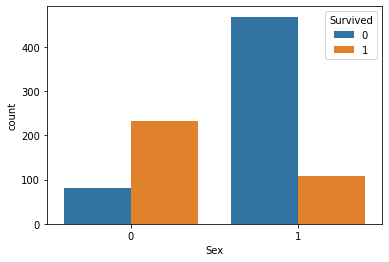

In [14]:
sns.countplot(x='Sex', data=train, hue = 'Survived')

<Axes: xlabel='Embarked', ylabel='count'>

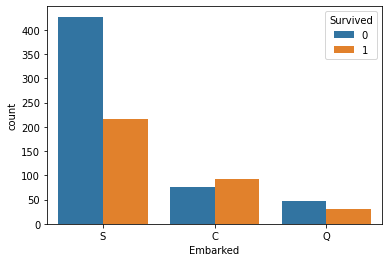

In [15]:
sns.countplot(x='Embarked', data=train, hue = 'Survived')

<Axes: xlabel='Pclass', ylabel='count'>

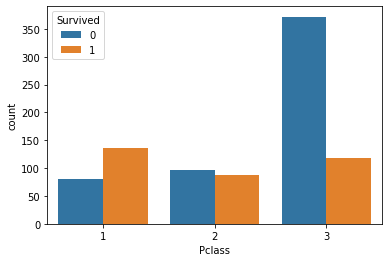

In [16]:
sns.countplot(x='Pclass', data=train, hue = 'Survived')

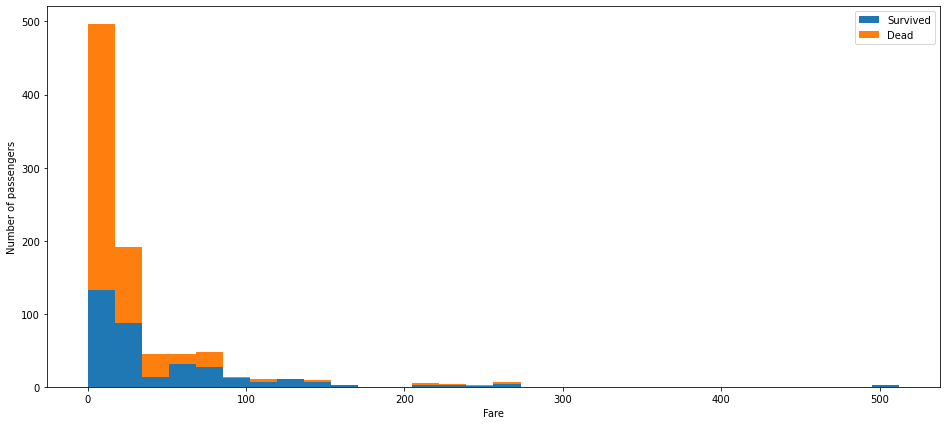

In [17]:
figure = plt.figure(figsize=(16, 7))
plt.hist([train[train['Survived'] == 1]['Fare'], train[train['Survived'] == 0]['Fare']], 
         stacked=True, bins = 30, label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend()

Creating new ticket features

In [18]:
ticket_char = []
ticket_num = []
ticket_only_char = []
ticket_only_num = []
for ticket in train['Ticket']:
    if ticket.isnumeric():
        ticket_num.append(ticket)
        ticket_char.append('num')
        ticket_only_char.append(0)
        ticket_only_num.append(1)
    else:
        ticket_char.append(ticket.rsplit(' ',1)[0])
        ticket_only_num.append(0)
        if len(ticket.split(' '))>1:
            ticket_num.append(ticket.rsplit(' ',1)[1])
            ticket_only_char.append(0)
        else:
            ticket_num.append('0')
            ticket_only_char.append(1)

In [19]:
ticket_num = ([int(x) for x in ticket_num])

In [20]:
eda=pd.DataFrame()
eda['Survived'] = train['Survived']
eda['Ticket_Num'] = ticket_num
eda['Ticket_Char'] = ticket_char
eda['Ticket_Only_Char'] = ticket_only_char
eda['Ticket_Only_Num'] = ticket_only_num
corr = eda.corr()
corr.style.background_gradient(cmap='coolwarm')

,Survived,Ticket_Num,Ticket_Only_Char,Ticket_Only_Num
Survived,1.000000,-0.095605,-0.018481,0.001492
Ticket_Num,-0.095605,1.000000,-0.030399,-0.094755
Ticket_Only_Char,-0.018481,-0.030399,1.000000,-0.113843
Ticket_Only_Num,0.001492,-0.094755,-0.113843,1.000000


In [21]:
eda = pd.get_dummies(eda, columns=['Ticket_Char'])
corr = eda.corr()
corr.style.background_gradient(cmap='coolwarm')

,Survived,Ticket_Num,Ticket_Only_Char,Ticket_Only_Num,Ticket_Char_A./5.,Ticket_Char_A.5.,Ticket_Char_A/4,Ticket_Char_A/4.,Ticket_Char_A/5,Ticket_Char_A/5.,Ticket_Char_A/S,Ticket_Char_A4.,Ticket_Char_C,Ticket_Char_C.A.,Ticket_Char_C.A./SOTON,Ticket_Char_CA,Ticket_Char_CA.,Ticket_Char_F.C.,Ticket_Char_F.C.C.,Ticket_Char_Fa,Ticket_Char_LINE,Ticket_Char_P/PP,Ticket_Char_PC,Ticket_Char_PP,Ticket_Char_S.C./A.4.,Ticket_Char_S.C./PARIS,Ticket_Char_S.O./P.P.,Ticket_Char_S.O.C.,Ticket_Char_S.O.P.,Ticket_Char_S.P.,Ticket_Char_S.W./PP,Ticket_Char_SC,Ticket_Char_SC/AH,Ticket_Char_SC/AH Basle,Ticket_Char_SC/PARIS,Ticket_Char_SC/Paris,Ticket_Char_SCO/W,Ticket_Char_SO/C,Ticket_Char_SOTON/O.Q.,Ticket_Char_SOTON/O2,Ticket_Char_SOTON/OQ,Ticket_Char_STON/O 2.,Ticket_Char_STON/O2.,Ticket_Char_SW/PP,Ticket_Char_W./C.,Ticket_Char_W.E.P.,Ticket_Char_W/C,Ticket_Char_WE/P,Ticket_Char_num
Survived,1.000000,-0.095605,-0.018481,0.001492,-0.037436,-0.037436,-0.045876,-0.045876,-0.062182,-0.044095,-0.026456,-0.026456,0.002496,0.035493,-0.026456,-0.064988,-0.050661,-0.026456,0.064285,-0.026456,-0.018481,0.011329,0.147062,0.033803,-0.026456,0.011329,-0.045876,-0.059292,-0.026456,-0.026456,0.042470,0.042470,0.011329,0.042470,0.002496,0.016040,-0.026456,0.042470,-0.050661,-0.037436,-0.044095,0.007887,0.019667,0.042470,-0.056649,-0.026456,-0.026456,0.011329,0.001492
Ticket_Num,-0.095605,1.000000,-0.030399,-0.094755,-0.021276,-0.020397,-0.022085,-0.023514,-0.046531,-0.039574,-0.015030,-0.012389,-0.033031,-0.073354,-0.013433,-0.037004,-0.042748,-0.014522,-0.032457,-0.001619,-0.030399,-0.021227,-0.114422,-0.025619,-0.013970,-0.021321,-0.026289,-0.032303,-0.015114,-0.014997,-0.015135,-0.015085,-0.020310,-0.015146,-0.033761,-0.030181,-0.015093,-0.014413,0.308592,0.202739,0.117889,0.499424,0.351947,-0.015135,-0.044448,-0.014881,-0.014448,-0.021056,-0.094755
Ticket_Only_Char,-0.018481,-0.030399,1.000000,-0.113843,-0.003185,-0.003185,-0.003903,-0.003903,-0.007155,-0.005976,-0.002251,-0.002251,-0.005045,-0.011871,-0.002251,-0.005529,-0.006392,-0.002251,-0.005045,-0.002251,1.000000,-0.003185,-0.018044,-0.003903,-0.002251,-0.003185,-0.003903,-0.005045,-0.002251,-0.002251,-0.002251,-0.002251,-0.003185,-0.002251,-0.005045,-0.004510,-0.002251,-0.002251,-0.006392,-0.003185,-0.005976,-0.007846,-0.005529,-0.002251,-0.006784,-0.002251,-0.002251,-0.003185,-0.113843
Ticket_Only_Num,0.001492,-0.094755,-0.113843,1.000000,-0.080408,-0.080408,-0.098535,-0.098535,-0.180613,-0.150855,-0.056825,-0.056825,-0.127352,-0.299683,-0.056825,-0.139586,-0.161362,-0.056825,-0.127352,-0.056825,-0.113843,-0.080408,-0.455525,-0.098535,-0.056825,-0.080408,-0.098535,-0.127352,-0.056825,-0.056825,-0.056825,-0.056825,-0.080408,-0.056825,-0.127352,-0.113843,-0.056825,-0.056825,-0.161362,-0.080408,-0.150855,-0.198077,-0.139586,-0.056825,-0.171247,-0.056825,-0.056825,-0.080408,1.000000
Ticket_Char_A./5.,-0.037436,-0.021276,-0.003185,-0.080408,1.000000,-0.002250,-0.002757,-0.002757,-0.005053,-0.004221,-0.001590,-0.001590,-0.003563,-0.008385,-0.001590,-0.003905,-0.004515,-0.001590,-0.003563,-0.001590,-0.003185,-0.002250,-0.012745,-0.002757,-0.001590,-0.002250,-0.002757,-0.003563,-0.001590,-0.001590,-0.001590,-0.001590,-0.002250,-0.001590,-0.003563,-0.003185,-0.001590,-0.001590,-0.004515,-0.002250,-0.004221,-0.005542,-0.003905,-0.001590,-0.004791,-0.001590,-0.001590,-0.002250,-0.080408
Ticket_Char_A.5.,-0.037436,-0.020397,-0.003185,-0.080408,-0.002250,1.000000,-0.002757,-0.002757,-0.005053,-0.004221,-0.001590,-0.001590,-0.003563,-0.008385,-0.001590,-0.003905,-0.004515,-0.001590,-0.003563,-0.001590,-0.003185,-0.002250,-0.012745,-0.002757,-0.001590,-0.002250,-0.002757,-0.003563,-0.001590,-0.001590,-0.001590,-0.001590,-0.002250,-0.001590,-0.003563,-0.003185,-0.001590,-0.001590,-0.004515,-0.002250,-0.004221,-0.005542,-0.003905,-0.001590,-0.004791,-0.001590,-0.001590,-0.002250,-0.080408
Ticket_Char_A/4,-0.045876,-0.022085,-0.003903,-0.098535,-0.002757,-0.002757,1.000000,-0.003378,-0.006193,-0.005172,-0.001948,-0.001

In [22]:
train = train_org.copy()
del train['PassengerId']

In [23]:
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Regular",
    "Ms": "Mrs",
    "Mr" : "Regular",
    "Mrs" : "Mrs",
    "Miss" : "Regular",
    "Master" : "Master",
    "Lady" : "Royalty"
}

In [24]:
train['Title'] = train['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())

In [25]:
eda=pd.DataFrame()
eda['Survived'] = train['Survived']
eda['Title'] = train.Title.map(Title_Dictionary)
eda = pd.get_dummies(eda, columns=['Title'])
corr = eda.corr()
corr.style.background_gradient(cmap='coolwarm')

,Survived,Title_Master,Title_Mrs,Title_Officer,Title_Regular,Title_Royalty
Survived,1.000000,0.085221,0.344935,-0.031316,-0.332824,0.033391
Title_Master,0.085221,1.000000,-0.088394,-0.031131,-0.416435,-0.016287
Title_Mrs,0.344935,-0.088394,1.000000,-0.058544,-0.783136,-0.030628
Title_Officer,-0.031316,-0.031131,-0.058544,1.000000,-0.275811,-0.010787
Title_Regular,-0.332824,-0.416435,-0.783136,-0.275811,1.000000,-0.144295
Title_Royalty,0.033391,-0.016287,-0.030628,-0.010787,-0.144295,1.000000


### Preprocessing Data

In [26]:
def format_data(data_org):
    data = data_org.copy()
    data['Title'] = data['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    ticket_char = []
    ticket_num = []
    ticket_only_char = []
    ticket_only_num = []
    for ticket in data['Ticket']:
        if ticket.isnumeric():
            ticket_num.append(ticket)
            ticket_char.append('num')
            ticket_only_char.append(0)
            ticket_only_num.append(1)
        else:
            ticket_char.append(ticket.rsplit(' ',1)[0])
            ticket_only_num.append(0)
            if len(ticket.split(' '))>1:
                ticket_num.append(ticket.rsplit(' ',1)[1])
                ticket_only_char.append(0)
            else:
                ticket_num.append('0')
                ticket_only_char.append(1)
    
    ticket_num = ([int(x) for x in ticket_num])
    data['Ticket_Num'] = ticket_num
    data['Ticket_Char'] = ticket_char
    data['Ticket_Only_Char'] = ticket_only_char
    data['Ticket_Only_Num'] = ticket_only_num
    data['Cabin'].fillna('U', inplace=True)
    data['Cabin'] = data['Cabin'].map(lambda c: c[0])

    sex = [0]*len(data)
    for i in range(len(data)):
        if data['Sex'].loc[i] == 'male':
            sex[i] = 1
    data['Sex'] = sex
    # a map of more aggregated title
    # we map each title
    data['Title'] = data.Title.map(Title_Dictionary)  
    data['Age'] = data.apply(lambda row: age_aproximate(row,data) if np.isnan(row['Age']) else row['Age'], axis=1)
    del data['Name']
    del data['Ticket']
    data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
    new_data = pd.get_dummies(data, columns=['Pclass','Embarked', 'Title', 'Ticket_Char','Cabin'])
    cols = new_data.columns.values
    scaler = MinMaxScaler()
    scaler.fit(new_data)
    scaled_features = scaler.transform(new_data)
    formatted = pd.DataFrame(scaled_features)
    formatted.columns = cols
    return formatted

In [27]:
format_train = format_data(train)

In [28]:
X = format_train.drop(['Survived'], axis = 1)
y = pd.DataFrame(format_train['Survived'])

Creating training and test set

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2,stratify = y,random_state =42)

In [30]:
threasholds = arange(0.6,0.4005,-0.001)

### Training the models

Function to find optimum threashold and output scores

In [31]:
def threashold_finder(prob, test):
    model_best_acc = 0
    model_best_F1 = 0
    model_threashold = 0
    same = []
    for t in threasholds:
        pred = []
        for p in prob[:,1]:
            if p>t:
                pred.append(1)
            else:
                pred.append(0)
        acc = accuracy_score(test, pred)
        F1 = f1_score(test, pred)

        if acc-model_best_acc>0.0001:
            same = []
            model_best_acc = acc
            model_best_F1 = F1
            model_threashold = t
            same.append(t)
        elif abs(acc-model_best_acc)<0.0001:
            if F1-model_best_F1>0.0001:
                same = []
                model_best_F1 = F1
                model_threashold = t
                same.append(t)
            elif abs(F1-model_best_F1)<0.0001:
                same.append(t)
    stop = -1
    if len(same)>1:
        for i in range(len(same)-1):
            if same[i]-same[i+1]>0.001:
                stop = i+1
    if stop!=1:
        threashold = same[0:stop]
    else:
        threashold = same
    
    avg_threashold = np.mean(threashold)
    
    pred = []
    for p in prob[:,1]:
        if p>avg_threashold:
            pred.append(1)
        else:
            pred.append(0)
    model_avg_acc=accuracy_score(test, pred)
    model_avg_F1 = f1_score(test, pred)
    
    matrix = pd.crosstab(test['Survived'].values, pred,rownames=['Actual'], colnames=['Predicted'], margins=True)
    
    print("Accuracy: " ,model_avg_acc)
    print("F1 Score: " ,model_avg_F1)
    print("Threashold: " ,avg_threashold)
    
    return pred, matrix,model_avg_acc, model_best_F1, avg_threashold

Random Forest Classifier using Bayes Search CV for hypertuning

In [32]:
param_RFC = { 
    'n_estimators': Integer(30, 5000),
    'max_features': Real(0.01, 1, 'uniform'),
    'criterion' :Categorical(['gini', 'entropy']),                
    'max_depth': Integer(1, 20),                  
    'min_samples_split': Real(0.01, 0.49999, 'uniform'),
    'min_samples_leaf': Real(0.01, 0.499999, 'uniform'),      
    'bootstrap' : Categorical(['True', 'False']),        
    'ccp_alpha': Real(0.01, 0.9999, 'uniform'),     
}

In [33]:
RFC=RandomForestClassifier(random_state=42)
RFC_clf = BayesSearchCV(estimator=RFC, search_spaces=param_RFC, cv= 5, scoring = 'accuracy', error_score = 1)

In [34]:
RFC_clf.fit(X_train, y_train['Survived'].values)

BayesSearchCV(cv=5, error_score=1,
              estimator=RandomForestClassifier(random_state=42),
              scoring='accuracy',
              search_spaces={'bootstrap': Categorical(categories=('True', 'False'), prior=None),
                             'ccp_alpha': Real(low=0.01, high=0.9999, prior='uniform', transform='normalize'),
                             'criterion': Categorical(categories=('gini', 'entropy'), prior=None),
                             'max_depth': Integer(low=1,...transform='normalize'),
                             'max_features': Real(low=0.01, high=1, prior='uniform', transform='normalize'),
                             'min_samples_leaf': Real(low=0.01, high=0.499999, prior='uniform', transform='normalize'),
                             'min_samples_split': Real(low=0.01, high=0.49999, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=30, high=5000, prior='uniform', transform='normalize')})

In [35]:
RFC_prob = RFC_clf.predict_proba(X_test)

In [36]:
print("Random Forest Classifier")
RFC_pred, RFC_confusion, RFC_best_acc, RFC_best_F1, RFC_threashold = threashold_finder(RFC_prob,y_test)
RFC_confusion

Random Forest Classifier
Accuracy:  0.8324022346368715
F1 Score:  0.7580645161290324
Threashold:  0.5045


Predicted,0,1,All
Actual,,,
0.0,102,8,110
1.0,22,47,69
All,124,55,179


Setting Random Forest Classifer as the best model for now

In [37]:
best = "Random Forest Classifier"
best_clf = RFC_clf
best_acc = RFC_best_acc
best_F1 = RFC_best_F1
best_threashold = RFC_threashold

Logistic Regression Classifier using Bayes Search CV for hypertuning

In [38]:
param_LOG = { 
    'solver': Categorical(['lbfgs','liblinear']),
    'C':Real(1e-6, 1e+1, prior='log-uniform'),
    'fit_intercept':Categorical([True,False])
}

In [39]:
LOG_grid=LogisticRegression(penalty = 'l2',max_iter = 1000, random_state=42)
LOG_clf = BayesSearchCV(estimator=LOG_grid, search_spaces=param_LOG, cv= 5, scoring = 'accuracy',error_score = 1)

In [40]:
LOG_clf.fit(X_train, y_train['Survived'].values)

BayesSearchCV(cv=5, error_score=1,
              estimator=LogisticRegression(max_iter=1000, random_state=42),
              scoring='accuracy',
              search_spaces={'C': Real(low=1e-06, high=10.0, prior='log-uniform', transform='normalize'),
                             'fit_intercept': Categorical(categories=(True, False), prior=None),
                             'solver': Categorical(categories=('lbfgs', 'liblinear'), prior=None)})

In [41]:
LOG_prob = LOG_clf.predict_proba(X_test)

In [42]:
print("Logistic Regression Classifier")
LOG_pred, LOG_confusion, LOG_best_acc, LOG_best_F1, LOG_threashold = threashold_finder(LOG_prob,y_test)
LOG_confusion

Logistic Regression Classifier
Accuracy:  0.8268156424581006
F1 Score:  0.7394957983193275
Threashold:  0.5814999999999999


Predicted,0,1,All
Actual,,,
0.0,104,6,110
1.0,25,44,69
All,129,50,179


Updating Best Model

In [43]:
if (LOG_best_acc-best_acc>0.0001) or (abs(LOG_best_acc-best_acc)<0.0001 and (LOG_best_F1-best_f1>0.0001)):
    best = "Logistic Regression Classifier"
    best_clf = LOG_clf
    best_acc = LOG_best_acc
    best_F1 = LOG_best_F1
    best_threashold = LOG_threashold

Support Vector Classifier(SVC) using Bayes Search CV for hypertuning

In [44]:
param_SVC = {
    'C':Real(1e-6, 1e+1, prior='log-uniform'),
    'gamma':Real(1e-6, 1e+1, prior='log-uniform'),
    'kernel':Categorical(['linear','rbf'])}

In [45]:
SVC_grid=SVC(random_state=42)
SVC_grid_clf = BayesSearchCV(estimator=SVC_grid, search_spaces=param_SVC, cv= 5, scoring = 'accuracy',error_score = 1)

In [46]:
SVC_grid_clf.fit(X_train, y_train['Survived'].values)

C:\Users\hamza\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\hamza\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\hamza\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\hamza\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BayesSearchCV(cv=5, error_score=1, estimator=SVC(random_state=42),
              scoring='accuracy',
              search_spaces={'C': Real(low=1e-06, high=10.0, prior='log-uniform', transform='normalize'),
                             'gamma': Real(low=1e-06, high=10.0, prior='log-uniform', transform='normalize'),
                             'kernel': Categorical(categories=('linear', 'rbf'), prior=None)})

In [47]:
SVC_clf=SVC.set_params(SVC_grid_clf.best_estimator_,probability = True )
SVC_clf.fit(X_train, y_train['Survived'].values)

SVC(C=2.090124223481419, gamma=1e-06, kernel='linear', probability=True,
    random_state=42)

In [48]:
SVC_prob = SVC_clf.predict_proba(X_test)

In [49]:
print("Support Vector Classifier")
SVC_pred, SVC_confusion,SVC_best_acc, SVC_best_F1, SVC_threashold = threashold_finder(SVC_prob,y_test)
SVC_confusion

Support Vector Classifier
Accuracy:  0.8212290502793296
F1 Score:  0.7611940298507462
Threashold:  0.4609999999999998


Predicted,0,1,All
Actual,,,
0.0,96,14,110
1.0,18,51,69
All,114,65,179


In [50]:
if (SVC_best_acc-best_acc>0.0001) or (abs(SVC_best_acc-best_acc)<0.0001 and (SVC_best_F1-best_f1>0.0001)):
    best = "Support Vector Classifier"
    best_clf = SVC_grid_clf
    best_acc = SVC_best_acc
    best_F1 = SVC_best_F1
    best_threashold = SVC_threashold

XGBoost Classifier using Bayes Search CV for hypertuning

In [51]:
param_XGB = {
        'learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'n_estimators': Integer(30, 5000),
        'min_child_weight': Real(0.01, 10.0, 'uniform'),
        'gamma': Real(0.01, 10.0, 'uniform'),
        'subsample': Real(0.01, 1.0, 'uniform'),
        'colsample_bytree': Real(0.01, 1.0, 'uniform'),
        'max_depth': Integer(1, 256)
        }

In [52]:
XGB_grid=XGBClassifier(objective='binary:logistic', verbosity=0)
XGB_clf = BayesSearchCV(estimator=XGB_grid, search_spaces=param_XGB, cv= 5, scoring = 'accuracy',error_score = 1)

In [53]:
XGB_clf.fit(X_train, y_train['Survived'].values)

BayesSearchCV(cv=5, error_score=1,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, gpu_id=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      lear...
                             'learning_rate': Real(low=0.01, high=1.0, prior='log-uniform', transform='normalize'),
                             'max_depth': Integer(low=1, high=256, prior='uniform', transform='normalize'),
           

In [54]:
XGB_prob = XGB_clf.predict_proba(X_test)

In [55]:
print("XGBoost Classifier")
XGB_pred, XGB_confusion, XGB_best_acc, XGB_best_F1, XGB_threashold = threashold_finder(XGB_prob, y_test)
XGB_confusion

XGBoost Classifier
Accuracy:  0.8100558659217877
F1 Score:  0.7384615384615385
Threashold:  0.5299999999999999


Predicted,0,1,All
Actual,,,
0.0,97,13,110
1.0,21,48,69
All,118,61,179


In [56]:
if (XGB_best_acc-best_acc>0.0001) or (abs(XGB_best_acc-best_acc)<0.0001 and (XGB_best_F1-best_f1>0.0001)):
    best = "XGBoost Classifier"
    best_clf = XGB_clf
    best_acc = XGB_best_acc
    best_F1 = XGB_best_F1
    best_threashold = XGB_threashold

LightGBM Classifier using Bayes Search CV for hypertuning

In [57]:
param_LGBM = {
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),    
    'n_estimators': Integer(30, 5000),                  
    'num_leaves': Integer(2, 512),                       
    'max_depth': Integer(-1, 256),                       
    'min_child_samples': Integer(1, 256),               
    'max_bin': Integer(100, 1000),                      
    'subsample': Real(0.01, 1.0, 'uniform'),          
    'subsample_freq': Integer(0, 10),                   
    'colsample_bytree': Real(0.01, 1.0, 'uniform'),      
    'min_child_weight': Real(0.01, 10.0, 'uniform'),     
    'reg_lambda': Real(1e-9, 100.0, 'log-uniform'),     
    'reg_alpha': Real(1e-9, 100.0, 'log-uniform'),      
    'scale_pos_weight': Real(1.0, 500.0, 'uniform'),     
        }

In [58]:
LGBM_grid = lgbm.LGBMClassifier(boosting_type='gbdt',metric='accuracy',objective='binary',n_jobs=1, verbose=-1,random_state=0)
LGBM_clf = BayesSearchCV(estimator=LGBM_grid, search_spaces=param_LGBM, cv= 5, scoring = 'accuracy',error_score = 1)

In [59]:
LGBM_clf.fit(X_train, y_train['Survived'].values)

BayesSearchCV(cv=5, error_score=1,
              estimator=LGBMClassifier(metric='accuracy', n_jobs=1,
                                       objective='binary', random_state=0,
                                       verbose=-1),
              scoring='accuracy',
              search_spaces={'colsample_bytree': Real(low=0.01, high=1.0, prior='uniform', transform='normalize'),
                             'learning_rate': Real(low=0.01, high=1.0, prior='log-uniform', transform='normalize'),
                             'max_bin': Integer(low=...
                             'reg_alpha': Real(low=1e-09, high=100.0, prior='log-uniform', transform='normalize'),
                             'reg_lambda': Real(low=1e-09, high=100.0, prior='log-uniform', transform='normalize'),
                             'scale_pos_weight': Real(low=1.0, high=500.0, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.01, high=1.0, prior='uniform', transform='normali

In [60]:
LGBM_prob = LGBM_clf.predict_proba(X_test)

In [61]:
print("LightGBM Classifier")
LGBM_pred, LGBM_confusion, LGBM_best_acc, LGBM_best_F1, LGBM_threashold = threashold_finder(LGBM_prob, y_test)
LGBM_confusion

LightGBM Classifier
Accuracy:  0.8044692737430168
F1 Score:  0.7286821705426356
Threashold:  0.4844999999999999


Predicted,0,1,All
Actual,,,
0.0,97,13,110
1.0,22,47,69
All,119,60,179


In [62]:
if (LGBM_best_acc-best_acc>0.0001) or (abs(LGBM_best_acc-best_acc)<0.0001 and (LGBM_best_F1-best_f1>0.0001)):
    best = "LightGBM Classifier"
    best_clf = LGBM_clf
    best_acc = LGBM_best_acc
    best_F1 = LGBM_best_F1
    best_threashold = LGBM_threashold

In [63]:
print('Best Model Found:')
print(best)
print("Accuracy: " ,best_acc)
print("F1 Score: " ,best_F1)
print("Threashold: " ,best_threashold)

Best Model Found:
Random Forest Classifier
Accuracy:  0.8324022346368715
F1 Score:  0.7580645161290324
Threashold:  0.5045


### Prediction

In [64]:
test=pd.read_csv('test.csv')

In [65]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [66]:
ID = test['PassengerId']
del test['PassengerId']

In [67]:
test_data = format_data(test)

In [68]:
train_col = X.columns.values
test_col = test_data.columns.values
for colum in train_col:
    if colum not in test_col:
        test_data[colum] = [0]*len(test_data)

In [69]:
train_col = X.columns.values
test_col = test_data.columns.values
for colum in test_col:
    if colum not in train_col:
        del test_data[colum]

In [70]:
test_data = test_data[train_col]

In [71]:
for column in test_data:
    if test_data[column].isnull().values.any():
        test_data[column].fillna(test_data[column].median(), inplace=True)        

Logistic Regression was found to perform better 

In [89]:
Y_prob = LOG_clf.predict_proba(test_data)

In [90]:
Y_pred = []
for prob in Y_prob[:,1]:
    if prob>LOG_threashold:
        Y_pred.append(1)
    else:
        Y_pred.append(0)

In [92]:
submission = pd.DataFrame({
        "PassengerId": ID,
        "Survived": Y_pred
    })
submission.to_csv('submission.csv', index=False)